<a href="https://colab.research.google.com/github/YogJoshi14/opencv_task/blob/main/Task_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1> Problem Statement :</h1>
Train your own custom object detector for detecting the given two objects using python, 

1.Laptop

2.Street light.

(Expected output will be like, if we pass video/frames as a input it will detect the given trained 
objects from the video/frames and display the bounding box for that detected object)

Model link:

[fastcnn with resnet50 backbone](https://drive.google.com/file/d/1ExpHnZaDPCLXrX00QNkYavxjAlcSeK09/view?usp=sharing)

In [1]:
!pip install fiftyone

     |████████████████████████████████| 1.1 MB 12.4 MB/s 
     |████████████████████████████████| 631 kB 49.1 MB/s 
     |████████████████████████████████| 29.2 MB 24 kB/s 
     |████████████████████████████████| 225 kB 49.9 MB/s 
     |████████████████████████████████| 106 kB 52.2 MB/s 
     |████████████████████████████████| 131 kB 50.4 MB/s 
     |████████████████████████████████| 79.9 MB 58 kB/s 
     |████████████████████████████████| 557 kB 43.6 MB/s 
     |████████████████████████████████| 13.2 MB 148 kB/s 
     |████████████████████████████████| 36.7 MB 64 kB/s 
     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 77 kB 5.6 MB/s 
     |████████████████████████████████| 58 kB 5.7 MB/s 
     |████████████████████████████████| 77 kB 5.7 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 77 kB 5.8 MB/s 
     |████████████████████████████████| 7.9 MB 16.2 MB/s 
     |███████████████████████

In [2]:
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F



In [3]:
label_list = ["laptop","traffic light"]
dataset = foz.load_zoo_dataset("coco-2017","validation").filter_labels("ground_truth",
        F("label").is_in(label_list)) 

 100% |██████|    1.9Gb/1.9Gb [7.3s elapsed, 0s remaining, 278.0Mb/s]       
Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_val2017.json'
 100% |██████|    6.1Gb/6.1Gb [22.5s elapsed, 0s remaining, 284.2Mb/s]      
Extracting images to '/root/fiftyone/coco-2017/validation/data'
Writing annotations to '/root/fiftyone/coco-2017/validation/labels.json'
Dataset info written to '/root/fiftyone/coco-2017/info.json'
Loading 'coco-2017' split 'validation'
 100% |███████████████| 5000/5000 [38.7s elapsed, 0s remaining, 117.4 samples/s]      
Dataset 'coco-2017-validation' created


In [4]:
dataset

Dataset:     coco-2017-validation
Media type:  image
Num samples: 373
Tags:        ['validation']
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. FilterLabels(field='ground_truth', filter={'$in': ['$$this.label', [...]]}, only_matches=True)

In [1]:
import torch

In [5]:
import torch
import fiftyone.utils.coco as fouc
from PIL import Image


class FiftyOneTorchDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        fiftyone_dataset,
        transforms=None,
        gt_field="ground_truth",
        classes=None,
    ):
        self.samples = fiftyone_dataset
        self.transforms = transforms
        self.gt_field = gt_field

        self.img_paths = self.samples.values("filepath")

        self.classes = classes
        if not self.classes:
            # Get list of distinct labels that exist in the view
            self.classes = self.samples.distinct(
                "%s.detections.label" % gt_field
            )

        if self.classes[0] != "background":
            self.classes = ["background"] + self.classes

        self.labels_map_rev = {c: i for i, c in enumerate(self.classes)}

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        sample = self.samples[img_path]
        metadata = sample.metadata
        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        area = []
        iscrowd = []
        detections = sample[self.gt_field].detections
        for det in detections:
            coco_obj = fouc.COCOObject.from_detection(
                det, metadata)
            x, y, w, h = coco_obj.bbox
            boxes.append([x, y, x + w, y + h])
            # print(self.labels_map_rev[det.label])
            labels.append(self.labels_map_rev[det.label])
            area.append(coco_obj.area)
            iscrowd.append(coco_obj.iscrowd)

        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        target["image_id"] = torch.as_tensor([idx])
        target["area"] = torch.as_tensor(area, dtype=torch.float32)
        target["iscrowd"] = torch.as_tensor(iscrowd, dtype=torch.int64)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.img_paths)

    def get_classes(self):
        return self.classes

In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [7]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../


Cloning into 'vision'...
remote: Enumerating objects: 36626, done.
remote: Counting objects: 100% (2125/2125), done.
remote: Compressing objects: 100% (503/503), done.
remote: Total 36626 (delta 1656), reused 1984 (delta 1579), pack-reused 34501
Receiving objects: 100% (36626/36626), 48.69 MiB | 23.19 MiB/s, done.
Resolving deltas: 100% (28187/28187), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [8]:
# Import functions from the torchvision references we cloned
from engine import train_one_epoch, evaluate
import utils

def do_training(model, torch_dataset, torch_dataset_test, num_epochs=4):
    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        torch_dataset, batch_size=2, shuffle=True, num_workers=2,
        collate_fn=utils.collate_fn)
    
    data_loader_test = torch.utils.data.DataLoader(
        torch_dataset_test, batch_size=1, shuffle=False, num_workers=2,
        collate_fn=utils.collate_fn)

    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print("Using device %s" % device)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=3,
                                                    gamma=0.1)

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

In [9]:
# From the torchvision references we cloned
import transforms as T

train_transforms = T.Compose([T.ToTensor(), T.RandomHorizontalFlip(0.5)])
test_transforms = T.Compose([T.ToTensor()])

In [10]:
# split the dataset in train and test set
train_view = dataset.take(300, seed=51)
test_view = dataset.exclude([s.id for s in train_view])

In [11]:
# use our dataset and defined transformations
torch_dataset = FiftyOneTorchDataset(train_view, train_transforms,
        classes=label_list)
torch_dataset_test = FiftyOneTorchDataset(test_view, test_transforms, 
        classes=label_list)

In [15]:
model = get_model(len(['lap','st'])+1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [13]:
do_training(model, torch_dataset, torch_dataset_test, num_epochs=8)

Using device cuda


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kerne

Epoch: [0]  [  0/150]  eta: 0:05:29  lr: 0.000039  loss: 1.4888 (1.4888)  loss_classifier: 1.0556 (1.0556)  loss_box_reg: 0.3549 (0.3549)  loss_objectness: 0.0588 (0.0588)  loss_rpn_box_reg: 0.0195 (0.0195)  time: 2.1951  data: 0.3954  max mem: 2116
Epoch: [0]  [ 10/150]  eta: 0:03:42  lr: 0.000374  loss: 1.1813 (1.0851)  loss_classifier: 0.8558 (0.8156)  loss_box_reg: 0.1706 (0.1924)  loss_objectness: 0.0292 (0.0594)  loss_rpn_box_reg: 0.0101 (0.0177)  time: 1.5917  data: 0.0467  max mem: 3359
Epoch: [0]  [ 20/150]  eta: 0:03:24  lr: 0.000709  loss: 0.7321 (0.8725)  loss_classifier: 0.3832 (0.5687)  loss_box_reg: 0.1706 (0.2045)  loss_objectness: 0.0292 (0.0656)  loss_rpn_box_reg: 0.0081 (0.0338)  time: 1.5449  data: 0.0114  max mem: 3654
Epoch: [0]  [ 30/150]  eta: 0:03:08  lr: 0.001044  loss: 0.5726 (0.7728)  loss_classifier: 0.2237 (0.4677)  loss_box_reg: 0.1719 (0.1991)  loss_objectness: 0.0317 (0.0628)  loss_rpn_box_reg: 0.0123 (0.0432)  time: 1.5584  data: 0.0113  max mem: 3654


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [ 0/73]  eta: 0:00:36  model_time: 0.3166 (0.3166)  evaluator_time: 0.0050 (0.0050)  time: 0.4991  data: 0.1753  max mem: 4026
Test:  [72/73]  eta: 0:00:00  model_time: 0.3500 (0.3388)  evaluator_time: 0.0020 (0.0044)  time: 0.3526  data: 0.0058  max mem: 4026
Test: Total time: 0:00:25 (0.3535 s / it)
Averaged stats: model_time: 0.3500 (0.3388)  evaluator_time: 0.0020 (0.0044)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [1]  [  0/150]  eta: 0:04:49  lr: 0.005000  loss: 0.1392 (0.1392)  loss_classifier: 0.0424 (0.0424)  loss_box_reg: 0.0879 (0.0879)  loss_objectness: 0.0077 (0.0077)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 1.9310  data: 0.3369  max mem: 4026
Epoch: [1]  [ 10/150]  eta: 0:03:40  lr: 0.005000  loss: 0.1878 (0.2552)  loss_classifier: 0.0655 (0.0814)  loss_box_reg: 0.0954 (0.1257)  loss_objectness: 0.0149 (0.0233)  loss_rpn_box_reg: 0.0118 (0.0248)  time: 1.5765  data: 0.0396  max mem: 4026
Epoch: [1]  [ 20/150]  eta: 0:03:33  lr: 0.005000  loss: 0.1973 (0.2403)  loss_classifier: 0.0655 (0.0750)  loss_box_reg: 0.0993 (0.1215)  loss_objectness: 0.0126 (0.0193)  loss_rpn_box_reg: 0.0133 (0.0245)  time: 1.6276  data: 0.0105  max mem: 4026
Epoch: [1]  [ 30/150]  eta: 0:03:13  lr: 0.005000  loss: 0.1998 (0.2443)  loss_classifier: 0.0684 (0.0794)  loss_box_reg: 0.1056 (0.1257)  loss_objectness: 0.0073 (0.0185)  loss_rpn_box_reg: 0.0080 (0.0208)  time: 1.6376  data: 0.0112  max mem: 4026


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [ 0/73]  eta: 0:00:35  model_time: 0.3141 (0.3141)  evaluator_time: 0.0023 (0.0023)  time: 0.4870  data: 0.1689  max mem: 4026
Test:  [72/73]  eta: 0:00:00  model_time: 0.3487 (0.3412)  evaluator_time: 0.0021 (0.0029)  time: 0.3558  data: 0.0069  max mem: 4026
Test: Total time: 0:00:25 (0.3549 s / it)
Averaged stats: model_time: 0.3487 (0.3412)  evaluator_time: 0.0021 (0.0029)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.553
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [2]  [  0/150]  eta: 0:04:27  lr: 0.005000  loss: 0.3675 (0.3675)  loss_classifier: 0.1692 (0.1692)  loss_box_reg: 0.1248 (0.1248)  loss_objectness: 0.0543 (0.0543)  loss_rpn_box_reg: 0.0192 (0.0192)  time: 1.7859  data: 0.3078  max mem: 4026
Epoch: [2]  [ 10/150]  eta: 0:03:32  lr: 0.005000  loss: 0.1752 (0.2239)  loss_classifier: 0.0655 (0.0921)  loss_box_reg: 0.0757 (0.0999)  loss_objectness: 0.0152 (0.0224)  loss_rpn_box_reg: 0.0060 (0.0095)  time: 1.5164  data: 0.0378  max mem: 4026
Epoch: [2]  [ 20/150]  eta: 0:03:20  lr: 0.005000  loss: 0.2002 (0.2454)  loss_classifier: 0.0745 (0.0882)  loss_box_reg: 0.0829 (0.1033)  loss_objectness: 0.0152 (0.0270)  loss_rpn_box_reg: 0.0060 (0.0269)  time: 1.5315  data: 0.0108  max mem: 4026
Epoch: [2]  [ 30/150]  eta: 0:03:05  lr: 0.005000  loss: 0.2154 (0.2396)  loss_classifier: 0.0744 (0.0819)  loss_box_reg: 0.1009 (0.1052)  loss_objectness: 0.0194 (0.0276)  loss_rpn_box_reg: 0.0066 (0.0249)  time: 1.5665  data: 0.0110  max mem: 4026


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [ 0/73]  eta: 0:00:35  model_time: 0.3177 (0.3177)  evaluator_time: 0.0027 (0.0027)  time: 0.4891  data: 0.1668  max mem: 4026
Test:  [72/73]  eta: 0:00:00  model_time: 0.3518 (0.3422)  evaluator_time: 0.0024 (0.0038)  time: 0.3568  data: 0.0060  max mem: 4026
Test: Total time: 0:00:26 (0.3562 s / it)
Averaged stats: model_time: 0.3518 (0.3422)  evaluator_time: 0.0024 (0.0038)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.372
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.427
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [3]  [  0/150]  eta: 0:04:30  lr: 0.000500  loss: 0.2317 (0.2317)  loss_classifier: 0.0885 (0.0885)  loss_box_reg: 0.1250 (0.1250)  loss_objectness: 0.0143 (0.0143)  loss_rpn_box_reg: 0.0038 (0.0038)  time: 1.8006  data: 0.3158  max mem: 4026
Epoch: [3]  [ 10/150]  eta: 0:03:50  lr: 0.000500  loss: 0.1381 (0.2067)  loss_classifier: 0.0472 (0.0510)  loss_box_reg: 0.0693 (0.0806)  loss_objectness: 0.0063 (0.0077)  loss_rpn_box_reg: 0.0037 (0.0674)  time: 1.6472  data: 0.0381  max mem: 4026
Epoch: [3]  [ 20/150]  eta: 0:03:33  lr: 0.000500  loss: 0.1381 (0.2075)  loss_classifier: 0.0440 (0.0590)  loss_box_reg: 0.0693 (0.0849)  loss_objectness: 0.0086 (0.0108)  loss_rpn_box_reg: 0.0053 (0.0529)  time: 1.6359  data: 0.0110  max mem: 4026
Epoch: [3]  [ 30/150]  eta: 0:03:14  lr: 0.000500  loss: 0.1133 (0.2158)  loss_classifier: 0.0440 (0.0648)  loss_box_reg: 0.0664 (0.0973)  loss_objectness: 0.0119 (0.0129)  loss_rpn_box_reg: 0.0055 (0.0408)  time: 1.6108  data: 0.0122  max mem: 4026


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [ 0/73]  eta: 0:00:35  model_time: 0.3113 (0.3113)  evaluator_time: 0.0027 (0.0027)  time: 0.4842  data: 0.1683  max mem: 4026
Test:  [72/73]  eta: 0:00:00  model_time: 0.3514 (0.3410)  evaluator_time: 0.0018 (0.0030)  time: 0.3533  data: 0.0058  max mem: 4026
Test: Total time: 0:00:25 (0.3539 s / it)
Averaged stats: model_time: 0.3514 (0.3410)  evaluator_time: 0.0018 (0.0030)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.590
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.369
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.412
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.443
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [4]  [  0/150]  eta: 0:04:10  lr: 0.000500  loss: 0.1201 (0.1201)  loss_classifier: 0.0326 (0.0326)  loss_box_reg: 0.0834 (0.0834)  loss_objectness: 0.0029 (0.0029)  loss_rpn_box_reg: 0.0012 (0.0012)  time: 1.6690  data: 0.3118  max mem: 4026
Epoch: [4]  [ 10/150]  eta: 0:03:45  lr: 0.000500  loss: 0.1424 (0.1341)  loss_classifier: 0.0415 (0.0435)  loss_box_reg: 0.0731 (0.0741)  loss_objectness: 0.0048 (0.0073)  loss_rpn_box_reg: 0.0056 (0.0093)  time: 1.6094  data: 0.0374  max mem: 4026
Epoch: [4]  [ 20/150]  eta: 0:03:33  lr: 0.000500  loss: 0.1424 (0.1469)  loss_classifier: 0.0414 (0.0430)  loss_box_reg: 0.0593 (0.0787)  loss_objectness: 0.0058 (0.0066)  loss_rpn_box_reg: 0.0058 (0.0186)  time: 1.6413  data: 0.0104  max mem: 4026
Epoch: [4]  [ 30/150]  eta: 0:03:12  lr: 0.000500  loss: 0.1436 (0.1664)  loss_classifier: 0.0407 (0.0480)  loss_box_reg: 0.0605 (0.0931)  loss_objectness: 0.0058 (0.0084)  loss_rpn_box_reg: 0.0029 (0.0169)  time: 1.6055  data: 0.0113  max mem: 4026


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [ 0/73]  eta: 0:00:36  model_time: 0.3137 (0.3137)  evaluator_time: 0.0025 (0.0025)  time: 0.4934  data: 0.1752  max mem: 4026
Test:  [72/73]  eta: 0:00:00  model_time: 0.3516 (0.3403)  evaluator_time: 0.0019 (0.0032)  time: 0.3543  data: 0.0064  max mem: 4026
Test: Total time: 0:00:25 (0.3543 s / it)
Averaged stats: model_time: 0.3516 (0.3403)  evaluator_time: 0.0019 (0.0032)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.363
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.393
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.141
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.413
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.474
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [5]  [  0/150]  eta: 0:04:29  lr: 0.000500  loss: 0.0925 (0.0925)  loss_classifier: 0.0371 (0.0371)  loss_box_reg: 0.0470 (0.0470)  loss_objectness: 0.0057 (0.0057)  loss_rpn_box_reg: 0.0027 (0.0027)  time: 1.7986  data: 0.3321  max mem: 4026
Epoch: [5]  [ 10/150]  eta: 0:03:59  lr: 0.000500  loss: 0.1424 (0.2200)  loss_classifier: 0.0540 (0.0624)  loss_box_reg: 0.0827 (0.1162)  loss_objectness: 0.0058 (0.0081)  loss_rpn_box_reg: 0.0087 (0.0333)  time: 1.7138  data: 0.0398  max mem: 4026
Epoch: [5]  [ 20/150]  eta: 0:03:34  lr: 0.000500  loss: 0.1725 (0.2261)  loss_classifier: 0.0545 (0.0615)  loss_box_reg: 0.1019 (0.1169)  loss_objectness: 0.0070 (0.0095)  loss_rpn_box_reg: 0.0136 (0.0382)  time: 1.6459  data: 0.0107  max mem: 4026
Epoch: [5]  [ 30/150]  eta: 0:03:11  lr: 0.000500  loss: 0.1502 (0.2007)  loss_classifier: 0.0518 (0.0577)  loss_box_reg: 0.0850 (0.1045)  loss_objectness: 0.0066 (0.0095)  loss_rpn_box_reg: 0.0094 (0.0289)  time: 1.5372  data: 0.0110  max mem: 4026


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [ 0/73]  eta: 0:00:35  model_time: 0.3125 (0.3125)  evaluator_time: 0.0021 (0.0021)  time: 0.4867  data: 0.1698  max mem: 4026
Test:  [72/73]  eta: 0:00:00  model_time: 0.3511 (0.3412)  evaluator_time: 0.0015 (0.0028)  time: 0.3534  data: 0.0058  max mem: 4026
Test: Total time: 0:00:25 (0.3545 s / it)
Averaged stats: model_time: 0.3511 (0.3412)  evaluator_time: 0.0015 (0.0028)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.361
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.610
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.136
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.406
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.474
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [6]  [  0/150]  eta: 0:04:30  lr: 0.000050  loss: 0.1558 (0.1558)  loss_classifier: 0.0421 (0.0421)  loss_box_reg: 0.0980 (0.0980)  loss_objectness: 0.0050 (0.0050)  loss_rpn_box_reg: 0.0107 (0.0107)  time: 1.8047  data: 0.3421  max mem: 4026
Epoch: [6]  [ 10/150]  eta: 0:03:38  lr: 0.000050  loss: 0.1538 (0.1588)  loss_classifier: 0.0421 (0.0467)  loss_box_reg: 0.0762 (0.0766)  loss_objectness: 0.0037 (0.0044)  loss_rpn_box_reg: 0.0039 (0.0311)  time: 1.5588  data: 0.0410  max mem: 4026
Epoch: [6]  [ 20/150]  eta: 0:03:26  lr: 0.000050  loss: 0.1538 (0.1832)  loss_classifier: 0.0489 (0.0548)  loss_box_reg: 0.0853 (0.0954)  loss_objectness: 0.0041 (0.0070)  loss_rpn_box_reg: 0.0050 (0.0259)  time: 1.5785  data: 0.0111  max mem: 4026
Epoch: [6]  [ 30/150]  eta: 0:03:14  lr: 0.000050  loss: 0.1565 (0.1802)  loss_classifier: 0.0525 (0.0526)  loss_box_reg: 0.0961 (0.0948)  loss_objectness: 0.0039 (0.0060)  loss_rpn_box_reg: 0.0060 (0.0268)  time: 1.6514  data: 0.0112  max mem: 4026


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [ 0/73]  eta: 0:00:35  model_time: 0.3178 (0.3178)  evaluator_time: 0.0024 (0.0024)  time: 0.4861  data: 0.1641  max mem: 4026
Test:  [72/73]  eta: 0:00:00  model_time: 0.3503 (0.3404)  evaluator_time: 0.0015 (0.0025)  time: 0.3523  data: 0.0058  max mem: 4026
Test: Total time: 0:00:25 (0.3530 s / it)
Averaged stats: model_time: 0.3503 (0.3404)  evaluator_time: 0.0015 (0.0025)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.608
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.380
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.408
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.464
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [7]  [  0/150]  eta: 0:05:36  lr: 0.000050  loss: 0.1231 (0.1231)  loss_classifier: 0.0323 (0.0323)  loss_box_reg: 0.0869 (0.0869)  loss_objectness: 0.0011 (0.0011)  loss_rpn_box_reg: 0.0029 (0.0029)  time: 2.2454  data: 0.3153  max mem: 4026
Epoch: [7]  [ 10/150]  eta: 0:03:55  lr: 0.000050  loss: 0.1682 (0.2029)  loss_classifier: 0.0428 (0.0629)  loss_box_reg: 0.0869 (0.1013)  loss_objectness: 0.0038 (0.0071)  loss_rpn_box_reg: 0.0058 (0.0316)  time: 1.6850  data: 0.0383  max mem: 4026
Epoch: [7]  [ 20/150]  eta: 0:03:33  lr: 0.000050  loss: 0.1682 (0.1918)  loss_classifier: 0.0453 (0.0576)  loss_box_reg: 0.0743 (0.1037)  loss_objectness: 0.0040 (0.0066)  loss_rpn_box_reg: 0.0058 (0.0239)  time: 1.6090  data: 0.0107  max mem: 4026
Epoch: [7]  [ 30/150]  eta: 0:03:13  lr: 0.000050  loss: 0.1419 (0.1805)  loss_classifier: 0.0481 (0.0552)  loss_box_reg: 0.0666 (0.0994)  loss_objectness: 0.0042 (0.0059)  loss_rpn_box_reg: 0.0056 (0.0200)  time: 1.5711  data: 0.0110  max mem: 4026


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [ 0/73]  eta: 0:00:36  model_time: 0.3269 (0.3269)  evaluator_time: 0.0023 (0.0023)  time: 0.4944  data: 0.1629  max mem: 4026
Test:  [72/73]  eta: 0:00:00  model_time: 0.3522 (0.3411)  evaluator_time: 0.0015 (0.0025)  time: 0.3522  data: 0.0055  max mem: 4026
Test: Total time: 0:00:25 (0.3535 s / it)
Averaged stats: model_time: 0.3522 (0.3411)  evaluator_time: 0.0015 (0.0025)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.609
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.409
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.460
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [38]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [18]:
torch.save(model.state_dict(), "/content/drive/MyDrive/fcnnresnet50.pth")

In [18]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image


In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLASSES = ['laptop','lights']
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

In [20]:
# model = Model()
model.load_state_dict(torch.load("/content/drive/MyDrive/fcnnresnet50.pth"))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [22]:
if torch.cuda.is_available():
    model.cuda()

In [25]:
model.cpu()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [27]:
# load the image from disk
image = cv2.imread('/content/drive/MyDrive/trf.PNG')
orig = image.copy()
# convert the image from BGR to RGB channel ordering and change the
# image from channels last to channels first ordering
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.transpose((2, 0, 1))
# add the batch dimension, scale the raw pixel intensities to the
# range [0, 1], and convert the image to a floating point tensor
image = np.expand_dims(image, axis=0)
image = image / 255.0
image = torch.FloatTensor(image)
# send the input to the device and pass the it through the network to
# get the detections and predictions
# image = image.to(DEVICE)
detections = model(image)[0]

[INFO] lights: 99.22%
[INFO] lights: 97.73%
[INFO] lights: 85.50%
[INFO] lights: 72.05%
[INFO] lights: 64.97%
[INFO] lights: 63.48%


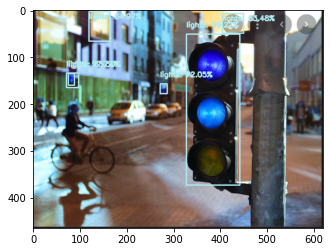

In [24]:
# loop over the detections
for i in range(0, len(detections["boxes"])):
	# extract the confidence (i.e., probability) associated with the
	# prediction
	confidence = detections["scores"][i]
	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > 0.6:
		# extract the index of the class label from the detections,
		# then compute the (x, y)-coordinates of the bounding box
		# for the object
		idx = int(detections["labels"][i])-1
		box = detections["boxes"][i].detach().cpu().numpy()
		(startX, startY, endX, endY) = box.astype("int")
		# display the prediction to our terminal
		label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
		print("[INFO] {}".format(label))
		# draw the bounding box and label on the image
		cv2.rectangle(orig, (startX, startY), (endX, endY),
			COLORS[idx], 2)
		y = startY - 15 if startY - 15 > 15 else startY + 15
		cv2.putText(orig, label, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)
# show the output image
plt.imshow(orig)